# FISH integrated analyses

## Libraries

In [1]:
# Importing libraries
import sys
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import pathlib
import warnings
warnings.filterwarnings("ignore")

## Directories Path

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('MS2-Cy3')
data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('GAPDH_Exon_Cy5')

In [3]:
# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

2021-10-26 20:08:38,114 [INFO] WRITING LOG OUTPUT TO /home/luisub/.cellpose/run.log


## Loading Files

In [4]:
#list_file_names, list_merged_images, number_images, output_to_path = fa.MergeChannels(data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =0).merge()
list_images, path_files, list_files_names, number_images = fa.ReadImages(data_dir).read()

In [5]:
selected_image = 4

In [6]:
channel_with_cytosol = [1,2]   # list or int
channel_with_nucleus = 0      # list or int
FISH_channel = 1              # int specific channel with FISH spots that are used for the quantification

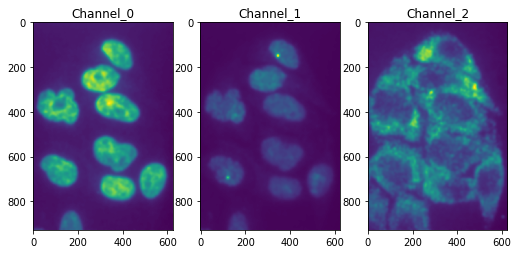

In [7]:
fa.PlotImages (list_images[selected_image],figsize=(8.5, 5) ).plot()

### Parameters for segmentation

In [8]:
diamter_nucleus = 200         #approximated nucleus size in pixels
diameter_cytosol = 250        # approximated cytosol size in pixels

## Cell Segmentation

2021-10-26 20:08:44,475 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 20:08:44,476 [INFO] >>>> using GPU
2021-10-26 20:08:44,627 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 20:08:44,628 [INFO] >>>> using GPU
2021-10-26 20:08:44,677 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 20:08:45,246 [INFO] >>>> TOTAL TIME 0.57 sec
2021-10-26 20:08:45,254 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 20:08:45,671 [INFO] >>>> TOTAL TIME 0.42 sec
2021-10-26 20:08:45,676 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 20:08:46,107 [INFO] >>>> TOTAL TIME 0.43 sec
2021-10-26 20:08:46,112 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 20:08:46,551 [INFO] >>>> TOTAL TIME 0.44 sec
2021-10-26 20:08:46,557 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 20:08:46,998 [INFO] >>>> TOTAL TIME 0.44 sec
2021-10-26 20:08:47,004 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 20:08:47,457 [INFO] >>>> TOTAL TIME 0.45 sec
2021-10-26 20:08:47,458 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 20:08:

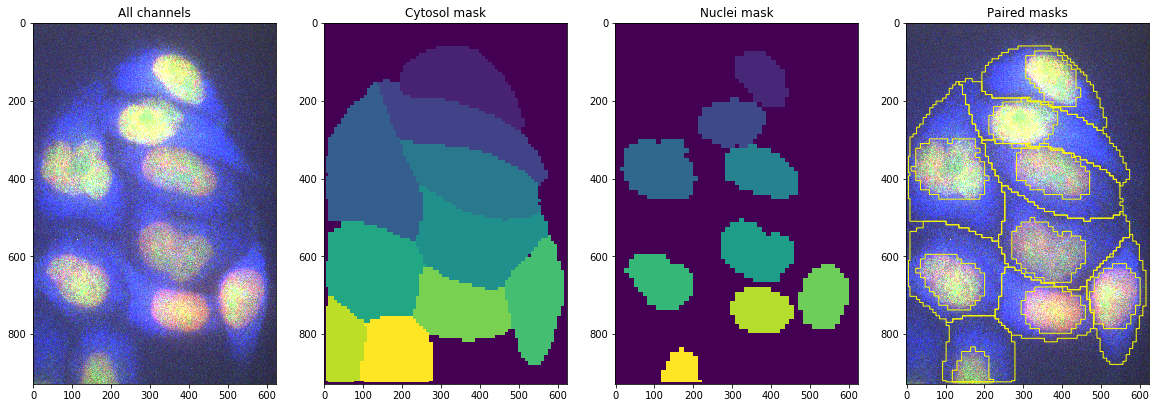

In [9]:
remove_fragmented_cells = False
masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei, index_paired_masks = fa.CellSegmentation(list_images[selected_image],channel_with_cytosol=channel_with_cytosol, channel_with_nucleus=channel_with_nucleus,diameter_cytosol = diameter_cytosol, diamter_nucleus=diamter_nucleus,remove_fragmented_cells= remove_fragmented_cells, show_plot=1).calculate_masks() 

## Spot Detection

### Parameters for spot detection

In [10]:
# Parameters for FISH detection
# Average spot size and shape
voxel_size_z = 300     # Height of a voxel, along the z axis, in nanometer. If None, image is considered in 2-d.
voxel_size_yx = 150    # Size of a voxel on the yx plan, in nanometer.
psf_z = 350            # Theoretical size of the PSF emitted by a spot in the z plan, in nanometer. If None, image is considered in 2-d.
psf_yx = 150           # Theoretical size of the PSF emitted by a spot in the yx plan, in nanometer.
# Cluster Detection
cluster_radius=500     # The maximum distance between two samples for one to be considered as in the neighborhood of the other. Radius expressed in nanometer.
minimum_spots_cluster=4   #The number of spots in a neighborhood for a point to be considered as a core point (from which a cluster is expanded). This includes the point itself.

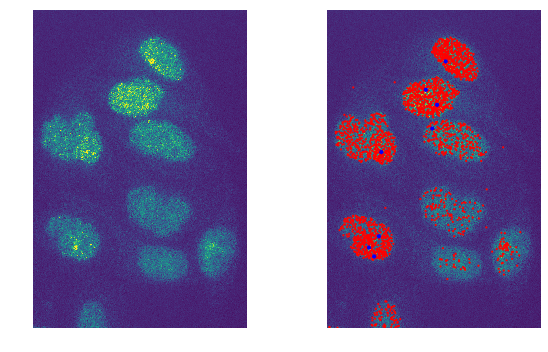

In [11]:
[spotDectionCSV, clusterDectionCSV] = fa.SpotDetection(list_images[selected_image],FISH_channel, voxel_size_z = voxel_size_z,voxel_size_yx = voxel_size_yx,psf_z = psf_z, psf_yx = psf_yx,cluster_radius=cluster_radius,minimum_spots_cluster=minimum_spots_cluster, show_plot=1).detect()

## Extracting data as a dataframe

In [12]:
dataframe_FISH = fa.DataProcessing(spotDectionCSV, clusterDectionCSV,masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei, dataframe =None).get_dataframe()

In [24]:
dataframe_FISH

AttributeError: 'DataFrame' object has no attribute 'save_t0_csv'

## Accessing data via conditional arguments

In [14]:
# Number of cells
number_cells = dataframe_FISH['cell_id'].nunique()
number_cells

9

In [15]:
# Nucleus size for all cells
nuc_area_all_cells = dataframe_FISH.loc[  (dataframe_FISH['spot_id']==0)  ].nuc_area_px.values
nuc_area_all_cells

array([14271, 17223, 24303, 19311, 22287, 17822, 16850, 15555,  6658])

In [16]:
cell_size = dataframe_FISH.loc[  (dataframe_FISH['spot_id']==0)  ].cell_area_px.values
cell_size

array([38199, 44158, 65654, 46103, 52141, 51101, 33954, 33694, 28212])

In [17]:
# Total NUMBER OF SPOTS in NUC 
spots_nuc = len( dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==False) & (dataframe_FISH['is_nuc']==True)  ] ) 
spots_nuc

2326

In [18]:
# AVERAGE NUMBER OF SPOTS PER NUC
avg_spots_nuc = len( dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==False) & (dataframe_FISH['is_nuc']==True)  ] )  / number_cells
avg_spots_nuc

258.44444444444446

In [19]:
# Number of RNA in a TS
ts_size =  dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True)  ].cluster_size.values
ts_size

array([33,  4,  5,  4,  4,  4, 19,  4])

In [20]:
# Number of spots
number_of_spots_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==False) & (dataframe_FISH['is_nuc']==True)  ].spot_id) for i in range(0, number_cells)]
number_of_spots_per_cell

[471, 487, 464, 215, 102, 445, 55, 26, 61]

In [21]:
# Number of TS per cell
number_of_TS_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True)  ].spot_id) for i in range(0, number_cells)]
number_of_TS_per_cell

[1, 2, 1, 1, 0, 3, 0, 0, 0]

# Plotting results

In [22]:
fig_size = (20, 5)
f = plt.figure(figsize=fig_size)
def plot_probability_distribution(data_to_plot, numBins = 10, title='', xlab='', ylab='', color='r', subplots=False, show_grid=True, fig=f):

  def normalization_hist (data,numBins=10):
    results, edges = np.histogram(data,bins=numBins, normed=True)
    binWidth = edges[1] - edges[0]
    return edges, results, binWidth
  edges, results, binWidth = normalization_hist (data_to_plot,numBins)
  plt.bar(edges[:-1], results*binWidth, binWidth,color=color)
  plt.xlabel(xlab, size=16)
  plt.ylabel(ylab, size=16)
  plt.grid(show_grid)
  plt.title(title, size=16)
  return (f)

<Figure size 1440x360 with 0 Axes>

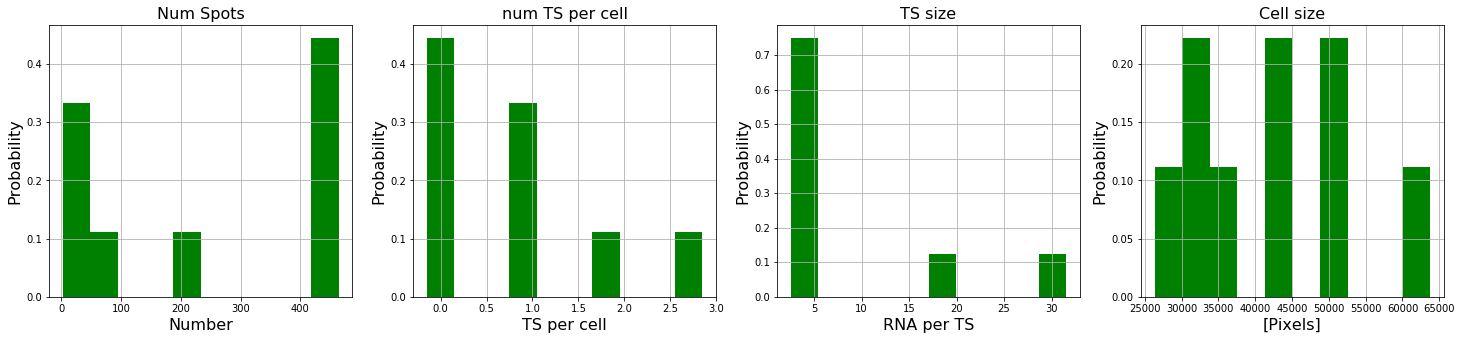

In [23]:
#Plotting
fig_size = (25, 5)
f = plt.figure(figsize=fig_size)
# adding subplots
f.add_subplot(1,4,1) 
plot_probability_distribution( number_of_spots_per_cell,   title='Num Spots', xlab='Number', ylab='Probability', fig=f, color='g')

f.add_subplot(1,4,2) 
plot_probability_distribution(number_of_TS_per_cell,     title='num TS per cell', xlab='TS per cell', ylab='Probability', fig=f, color='g')

f.add_subplot(1,4,3) 
plot_probability_distribution(ts_size,     title='TS size', xlab='RNA per TS', ylab='Probability', fig=f, color='g')

f.add_subplot(1,4,4) 
plot_probability_distribution(cell_size  , title='Cell size', xlab='[Pixels]', ylab='Probability', fig=f, color='g')

# plt.savefig('./results/sim_intensity_dist_ch0.png')
plt.show()